<a href="https://colab.research.google.com/github/armen1s/BOT/blob/main/CatB_Test4_Iter_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libs

In [2]:
#@title Install libs
!pip install catboost
!pip install ccxt

"""
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
"""

!pip install TA-Lib-Precompiled
!pip install numpy==1.24.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 101.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
pymc 5.23.0 requires numpy>=1.

In [ ]:
from logging import warning
#@title Load libs
import numpy as np

# Data Management
import pandas as pd

# Machine Learning
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

#Sampling Methods
from imblearn.over_sampling import ADASYN

#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Binary Classification Specific Metrics
from sklearn.metrics import RocCurveDisplay as plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay


# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

from hyperopt import fmin, tpe, hp
from pandas_datareader.data import DataReader

import json
from datetime import datetime
import talib as ta
import ccxt

import matplotlib.pyplot as plt

from tqdm import tqdm
import pickle as pk
import joblib

#Functions

In [ ]:
import numpy as np
import pandas as pd
import talib as ta


def get_indicators(data, timeframes, volatility_look_back, supertrend_multiplier=3):
    """
    Возвращает датафрейм с индикаторами:
        – классические (ATR, RSI, VWAP, Supertrend …)
        – «нишумовые» фичи для распознавания нулевого класса
    """
    df = data.copy()

    # ----------------------------------------------------------
    # ❶ Цикл по каждому тайм‑фрейму
    # ----------------------------------------------------------
    for timeframe in timeframes:
        # --- базовые индикаторы
        df[f'ATR_{timeframe}']  = ta.ATR(df['high'], df['low'], df['close'], timeperiod=timeframe)
        df[f'RSI_{timeframe}']  = ta.RSI(df['close'], timeperiod=timeframe)


        df[f'CCI_{timeframe}']  = ta.CCI(df['high'], df['low'], df['close'], timeperiod=timeframe)

        # --- DPO
        offset = timeframe // 2 + 1
        sma    = df['close'].rolling(window=timeframe).mean()
        df[f'DPO_{timeframe}'] = df['close'].shift(offset) - sma
        dpo_range = df[f'DPO_{timeframe}'].rolling(window=timeframe).apply(lambda x: x.max() - x.min())
        df[f'DPO_flat_{timeframe}'] = (dpo_range < 0.01).astype(int)






        # ------------------------------------------------------
        # ❷ «Тишинные» фичи для нулевого класса
        # ------------------------------------------------------
        # амплитуда и тело свечи
        df['range_abs']   = df['high'] - df['low']
        df['candle_body'] = (df['open'] - df['close']).abs()





    # ----------------------------------------------------------
    # ❸ Глобальные метрики
    # ----------------------------------------------------------
    df["returns"]    = (df["close"] / df["close"].shift(volatility_look_back)) - 1
    df["range"]      = (df["high"] / df["low"]) - 1
    df["volatility"] = df["returns"].rolling(window=volatility_look_back).std(ddof=0)

    # Volume‑based
    df['ADL'] = ta.AD(df['high'], df['low'], df['close'], df['volume'])
    df['ROC'] = ta.ROC(df['close'], timeperiod=volatility_look_back)


    # Momentu
    df['PSAR'] = ta.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)
    df['ADX']  = ta.ADX(df['high'], df['low'], df['close'], timeperiod=volatility_look_back)

    return df

In [ ]:
#@title New Mark Function
def get_shifts(df, K=4): #(data, K=4):
    #df=data.copy()
    for i in range(K):
        name_back=f'shift_{i}'
        name_frorward=f'shift_-{i}'
        df[name_back]=df['close'].shift(i)
        df[name_frorward]=df['close'].shift(-i)
    df.dropna(inplace=True)
    #return df

def get_coefs(df, K=4): #data, K=4):
    #df=data.copy()

    #get means
    back_col_names=[f'shift_{i}' for i in range(K)]
    frorward_col_names=[f'shift_-{i}' for i in range(K)]
    back_result=[i.mean() for i in df[back_col_names].values]
    frorward_result=[i.mean() for i in df[frorward_col_names].values]
    df['mean_back']=back_result
    df['mean_frorward']=frorward_result

    #get coefs
    df['coef']=(df['mean_frorward']-df['mean_back'])/df['mean_back']
    #return df

def get_classes(df,std_corrector=1): #data, std_corrector=1):
    #df=data.copy()
    long_thold=df['coef'][df['coef']>=0].mean()-df['coef'][df['coef']>=0].std()/std_corrector
    short_thold=df['coef'][df['coef']<0].mean()+df['coef'][df['coef']<0].std()/std_corrector
    df['target']=0
    df['target'][df['coef']>long_thold]=1
    df['target'][df['coef']<short_thold]=2 #-1
    #return df

def get_lbls(data, K=4, std_corrector=1):
    df=data.copy()
    get_shifts(df, K)
    get_coefs(df, K)
    get_classes(df, std_corrector)

    return df

In [ ]:
#@title Indicators adding function
def add_indicators(data,
                   timeframes = [2, 4, 7, 8, 10, 12, 14],
                   volatility_look_back= 2):
    df_w_indicators=get_indicators(data,
                               timeframes,
                               volatility_look_back)
    df_w_indicators.dropna(inplace=True)

    # Apply np.isinf and np.isnan to numerical columns only
    numerical_cols = df_w_indicators.select_dtypes(include=np.number).columns
    # Recalculate inf_mask using df_cleaned instead of df_w_indicators
    inf_mask = np.isinf(df_w_indicators[numerical_cols]) | np.isnan(df_w_indicators[numerical_cols])

    # Update the rest of the code accordingly
    df_cleaned = df_w_indicators[~inf_mask.any(axis=1)]
    # Use numerical_cols for column selection to ensure alignment
    df = df_cleaned.loc[:, numerical_cols[~inf_mask.any(axis=0)]]
    df.dropna(inplace=True)
    return df

#Data preparation

In [ ]:
#@title Read csv
five_min_df = pd.read_csv('/content/5m_2025-04-29_2025-06-27_bybit_btcusdt_ohlcv.csv')

# Удаляем строки, где timestamp равен '2' (или содержит некорректные данные)
five_min_df = five_min_df[five_min_df['timestamp'] != '2']

# Удаляем строки с пустым volume
five_min_df = five_min_df.dropna(subset=['volume'])

# Преобразуем столбец 'timestamp' в datetime
five_min_df['timestamp'] = pd.to_datetime(five_min_df['timestamp'])

# Устанавливаем столбец 'timestamp' в качестве индекса
five_min_df.set_index('timestamp', inplace=True)

five_min_df = five_min_df.tail(9000)

print(f"Исходный размер DataFrame: {len(five_min_df)}")

Исходный размер DataFrame: 9000


In [ ]:
#@title Primary split
train_splitter=round(len(five_min_df)*0.7)
train=five_min_df.iloc[:train_splitter]


val_splitter=round(len(five_min_df)*0.85)
val=five_min_df.iloc[:val_splitter]

test=five_min_df.copy()

In [ ]:
#@title Adding indicators to train/test/val
train_w_ind=add_indicators(train)
val_w_ind=add_indicators(val)
test_w_ind=add_indicators(test)

In [ ]:
#@title Add target (New)

STD_CORRECTOR = 2 #@param {type: "integer"}
K = 4 #@param {type: "integer"}

train_input=get_lbls(train_w_ind, K=K, std_corrector=STD_CORRECTOR)
val_input=get_lbls(val_w_ind, K=K, std_corrector=STD_CORRECTOR)
test_input=get_lbls(test_w_ind, K=K, std_corrector=STD_CORRECTOR)
train_input=train_input.reset_index()
val_input=val_input.reset_index()
test_input=test_input.reset_index()

drop_cols=[f'shift_-{i}' for i in range(K)]
#drop_cols.append('mean_frorward')
test_input=test_input.drop(columns=drop_cols)
val_input=val_input.drop(columns=drop_cols)
train_input=train_input.drop(columns=drop_cols)


#keys=list(train_input.keys())
#keys.append('target')
#df.head()
#df['target'].hist()

/tmp/ipython-input-7-450657997.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['target'][df['coef']>long_thold]=1
/tmp/ipython-input-7-450657997.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

<Axes: >

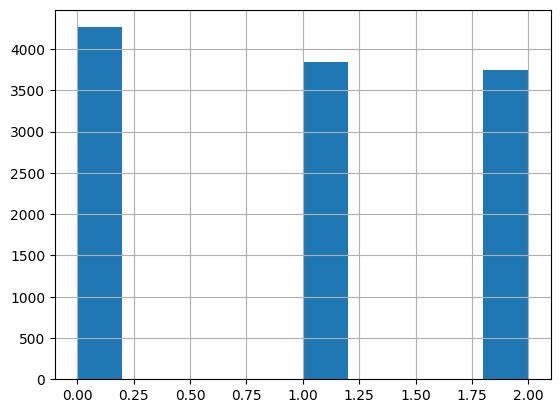

In [ ]:
#@title Look at class balance
train_input['target'].hist()

#Train

In [ ]:
#@title StandardScaler + Final split
scaler = StandardScaler()

train_target=train_input.iloc[:, -1].copy()
train_input=train_input.iloc[:,1 : -3].copy() # -3 to exclude coef and mean_forward

train_input=scaler.fit_transform(train_input)

val_target=val_input.iloc[:, -1].copy()
val_input=val_input.iloc[:,1 : -3].copy()
val_input=scaler.transform(val_input)
val_target=val_target.iloc[train_splitter:]
val_input=val_input[train_splitter:]

test_target=test_input.iloc[:, -1].copy()
test_input=test_input.iloc[:,1 : -3].copy()
test_input=scaler.transform(test_input)
test_target=test_target.iloc[val_splitter:]
test_input=test_input[val_splitter:]

In [1]:
pip install rgf_python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.8/757.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
#@title Set models and Run train


catboost_classifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.15,
    depth=12,
    rsm=0.9,
    boosting_type='Ordered',
    class_weights=[3, 5, 4],  # порядок: [0, 1, 2]
    random_seed=42,
    verbose=0
)

classifiers = [
               ('CatBoost', catboost_classifier)
               ]

voting_classifier = VotingClassifier(estimators=classifiers, voting='soft')

# если ты хочешь, чтобы веса работали и в GradientBoostingClassifier, — добавь:
from sklearn.utils.class_weight import compute_sample_weight
sample_w = compute_sample_weight(class_weight={0: 3, 1: 5, 2: 4}, y=train_target)

# Train the VotingClassifier on the training data
voting_classifier.fit(train_input, train_target, sample_weight=sample_w)

VotingClassifier(estimators=[('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x79e513508c50>)],
                 voting='soft')

0:	learn: 1.0355683	total: 781ms	remaining: 13m
100:	learn: 0.7175105	total: 29.8s	remaining: 4m 25s
200:	learn: 0.6294505	total: 56.8s	remaining: 3m 45s
300:	learn: 0.5589113	total: 1m 23s	remaining: 3m 14s
400:	learn: 0.5021313	total: 1m 50s	remaining: 2m 45s
500:	learn: 0.4520183	total: 2m 17s	remaining: 2m 17s
600:	learn: 0.4092235	total: 2m 44s	remaining: 1m 49s
700:	learn: 0.3728492	total: 3m 11s	remaining: 1m 21s
800:	learn: 0.3403479	total: 3m 38s	remaining: 54.3s
900:	learn: 0.3121002	total: 4m 5s	remaining: 27s
999:	learn: 0.2884316	total: 4m 32s	remaining: 0us


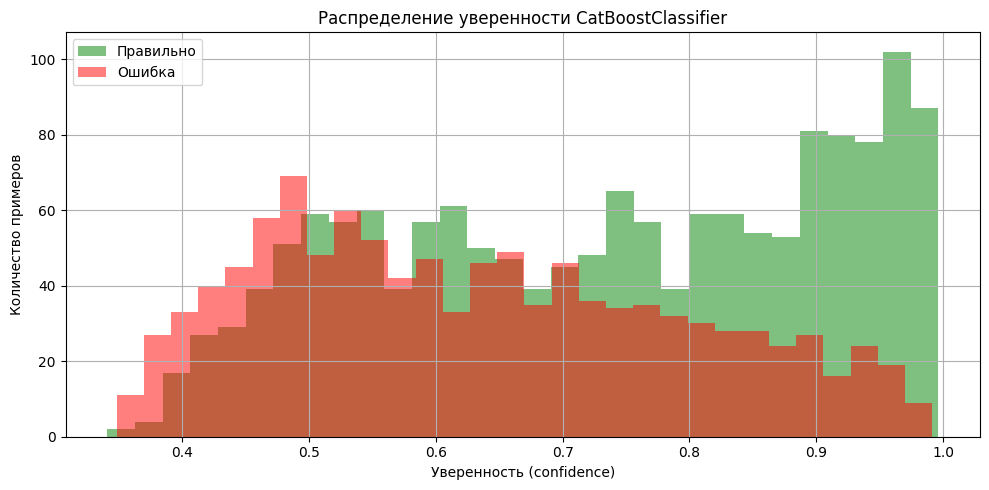

Точность модели CatBoost: 0.5879


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Обучение модели
catboost_classifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.15,
    depth=6,
    rsm=0.9,
    boosting_type='Ordered',

    class_weights=[2, 3, 3],  # [0, 1, 2]
    verbose=100,
    random_state=42
)

catboost_classifier.fit(train_input, train_target)

# Предсказания и вероятности
X_full = np.vstack((val_input, test_input))
y_full = np.hstack((val_target.values, test_target.values))

probs = catboost_classifier.predict_proba(X_full)
preds = catboost_classifier.predict(X_full)
confidences = probs.max(axis=1)
correct_mask = (preds.reshape(-1) == y_full)

# DataFrame для анализа
cb_results = pd.DataFrame({
    'true': y_full,
    'pred': preds.reshape(-1),
    'confidence': confidences,
    'correct': correct_mask
})

# Гистограмма
plt.figure(figsize=(10, 5))
plt.hist(cb_results[cb_results['correct']]['confidence'], bins=30, alpha=0.5, label='Правильно', color='green')
plt.hist(cb_results[~cb_results['correct']]['confidence'], bins=30, alpha=0.5, label='Ошибка', color='red')
plt.xlabel('Уверенность (confidence)')
plt.ylabel('Количество примеров')
plt.title('Распределение уверенности CatBoostClassifier')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Метрика точности для справки
acc_cb = accuracy_score(y_full, preds)
print(f"Точность модели CatBoost: {acc_cb:.4f}")

Ensemble Accuracy: 0.5859969558599696
Classification Report (Entire Dataset):
              precision    recall  f1-score   support

           0       0.55      0.32      0.40       896
           1       0.58      0.77      0.66       844
           2       0.61      0.68      0.65       888

    accuracy                           0.59      2628
   macro avg       0.58      0.59      0.57      2628
weighted avg       0.58      0.59      0.57      2628

Confusion Matrix (Entire Dataset):
[[285 326 285]
 [ 96 648 100]
 [134 147 607]]
Confusion Matrix - Entire Dataset:


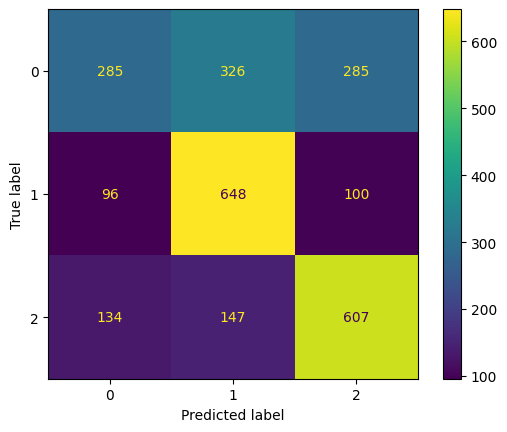

In [ ]:
#@title Test (new) (StandartSclaer)
pred_target = voting_classifier.predict(np.vstack((val_input,test_input)))
accuracy = accuracy_score(np.hstack((val_target.values, test_target.values)), pred_target)
print("Ensemble Accuracy:", accuracy)


print("Classification Report (Entire Dataset):")
print(classification_report(np.hstack((val_target.values, test_target.values)), pred_target))
print("Confusion Matrix (Entire Dataset):")
print(confusion_matrix(np.hstack((val_target.values, test_target.values)), pred_target))
cm_target = confusion_matrix(np.hstack((val_target.values, test_target.values)), pred_target)
print("Confusion Matrix - Entire Dataset:")
ConfusionMatrixDisplay(cm_target).plot()

In [ ]:
#@title Save VC
joblib.dump(voting_classifier, 'voting_classifier_110420255.pkl')

['voting_classifier_110420255.pkl']

#Spliting test array to test1 as val and test2 as main test. Using val to search right confidence

In [ ]:
predicted_classes = voting_classifier.predict(val_input)
predicted_probs = voting_classifier.predict_proba(val_input)

n_classes = predicted_probs.shape[1]
results_df = pd.DataFrame(predicted_probs, columns=[f'prob_class_{i}' for i in range(n_classes)])

# Добавляем истинные и предсказанные метки
results_df['true_target'] = val_target.values
results_df['predicted_target'] = predicted_classes

# Вычисляем уверенность: максимальное значение вероятности для каждого примера
results_df['confidence'] = predicted_probs.max(axis=1)

# Флаг: предсказание правильное или нет
results_df['correct'] = results_df['true_target'] == results_df['predicted_target']

# Вычисляем соотношение между максимальной и второй по величине вероятностью
# Сначала сортируем вероятности по каждой строке
sorted_probs = np.sort(predicted_probs, axis=1)
# Последний столбец — максимальное значение, предпоследний — второй максимум.
results_df['ratio_max_second'] = sorted_probs[:, -1] / sorted_probs[:, -2]

print(results_df.head())

   prob_class_0  prob_class_1  prob_class_2  true_target  predicted_target  \
0      0.089057      0.290109      0.620834            0                 2   
1      0.116003      0.667041      0.216956            1                 1   
2      0.033351      0.883289      0.083360            1                 1   
3      0.050114      0.926065      0.023821            0                 1   
4      0.136630      0.599645      0.263725            2                 1   

   confidence  correct  ratio_max_second  
0    0.620834    False          2.140002  
1    0.667041     True          3.074537  
2    0.883289     True         10.596040  
3    0.926065    False         18.479179  
4    0.599645    False          2.273746  


In [ ]:
# Средняя уверенность
mean_confidence_correct = results_df[results_df['correct']]['confidence'].mean()
mean_confidence_wrong = results_df[~results_df['correct']]['confidence'].mean()

print("Средняя уверенность на верных предсказаниях:", mean_confidence_correct)
print("Средняя уверенность на ошибочных предсказаниях:", mean_confidence_wrong)

# Среднее соотношение вероятностей (макс/второй максимум)
mean_ratio_correct = results_df[results_df['correct']]['ratio_max_second'].mean()
mean_ratio_wrong = results_df[~results_df['correct']]['ratio_max_second'].mean()

print("Среднее соотношение (макс/второй максимум) на верных предсказаниях:", mean_ratio_correct)
print("Среднее соотношение (макс/второй максимум) на ошибочных предсказаниях:", mean_ratio_wrong)

Средняя уверенность на верных предсказаниях: 0.8320384814756793
Средняя уверенность на ошибочных предсказаниях: 0.7348851062342647
Среднее соотношение (макс/второй максимум) на верных предсказаниях: 322.5722732468054
Среднее соотношение (макс/второй максимум) на ошибочных предсказаниях: 33.03578374366892


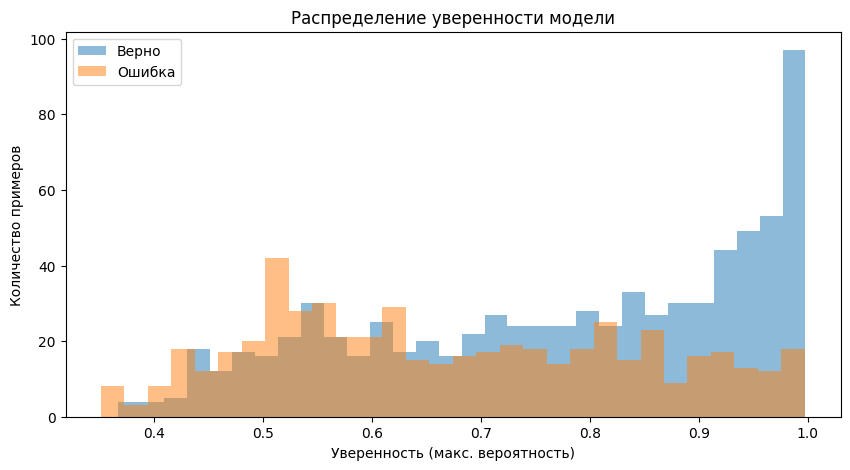

In [ ]:
 plt.figure(figsize=(10, 5))

# Гистограмма для верных предсказаний
plt.hist(results_df[results_df['correct']]['confidence'], bins=30, alpha=0.5, label='Верно')

# Гистограмма для ошибочных предсказаний
plt.hist(results_df[~results_df['correct']]['confidence'], bins=30, alpha=0.5, label='Ошибка')

plt.xlabel('Уверенность (макс. вероятность)')
plt.ylabel('Количество примеров')
plt.title('Распределение уверенности модели')
plt.legend()
plt.show()

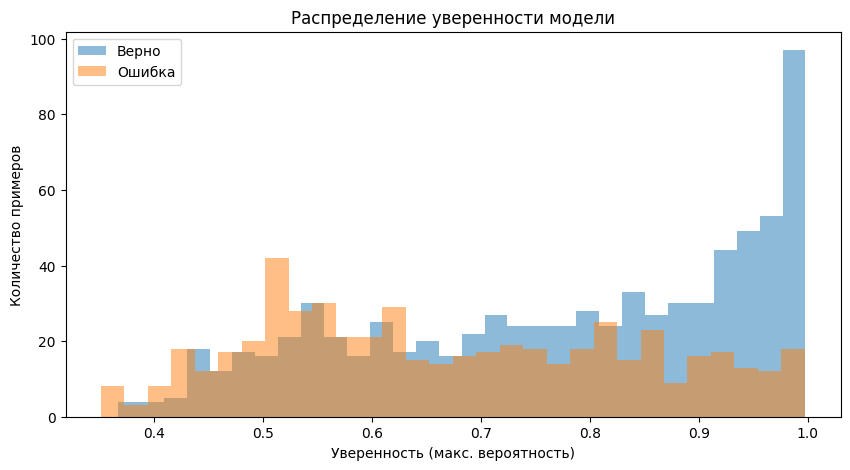

--- Уверенность > 0.905 ---
Всего примеров: 317
Верных предсказаний: 254 (80.13%)
Ошибок: 63 (19.87%)

--- Уверенность > 0.95 ---
Всего примеров: 196
Верных предсказаний: 163 (83.16%)
Ошибок: 33 (16.84%)



In [ ]:
import matplotlib.pyplot as plt

# Гистограмма
plt.figure(figsize=(10, 5))
plt.hist(results_df[results_df['correct']]['confidence'], bins=30, alpha=0.5, label='Верно')
plt.hist(results_df[~results_df['correct']]['confidence'], bins=30, alpha=0.5, label='Ошибка')

plt.xlabel('Уверенность (макс. вероятность)')
plt.ylabel('Количество примеров')
plt.title('Распределение уверенности модели')
plt.legend()
plt.show()

# Анализ при разных порогах уверенности
for threshold in [0.905, 0.95]:
    subset = results_df[results_df['confidence'] > threshold]
    total = len(subset)
    correct = subset['correct'].sum()
    incorrect = total - correct
    accuracy = correct / total * 100 if total > 0 else 0
    error_rate = incorrect / total * 100 if total > 0 else 0

    print(f'--- Уверенность > {threshold} ---')
    print(f'Всего примеров: {total}')
    print(f'Верных предсказаний: {correct} ({accuracy:.2f}%)')
    print(f'Ошибок: {incorrect} ({error_rate:.2f}%)\n')

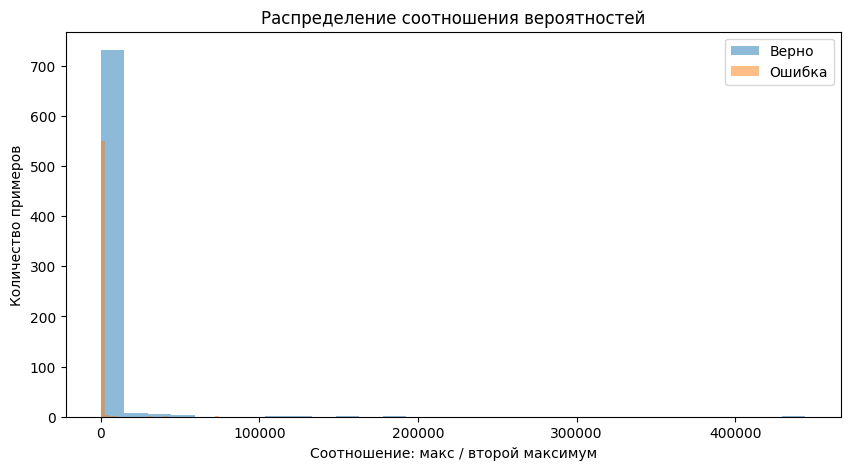

In [ ]:
plt.figure(figsize=(10, 5))

plt.hist(results_df[results_df['correct']]['ratio_max_second'], bins=30, alpha=0.5, label='Верно')
plt.hist(results_df[~results_df['correct']]['ratio_max_second'], bins=30, alpha=0.5, label='Ошибка')

plt.xlabel('Соотношение: макс / второй максимум')
plt.ylabel('Количество примеров')
plt.title('Распределение соотношения вероятностей')
plt.legend()
plt.show()

#Using test with val confidence to predict classes 1 and 2

In [ ]:
predicted_classes2 = voting_classifier.predict(test_input)
predicted_probs2 = voting_classifier.predict_proba(test_input)

n_classes = predicted_probs2.shape[1]
results_df2 = pd.DataFrame(predicted_probs2, columns=[f'prob_class_{i}' for i in range(n_classes)])

# Добавляем истинные и предсказанные метки
results_df2['true_target'] = test_target.values
results_df2['predicted_target'] = predicted_classes2

# Вычисляем уверенность: максимальное значение вероятности для каждого примера
results_df2['confidence'] = predicted_probs2.max(axis=1)

# Флаг: предсказание правильное или нет
results_df2['correct'] = results_df2['true_target'] == results_df2['predicted_target']

sorted_probs = np.sort(predicted_probs2, axis=1)
# Последний столбец — максимальное значение, предпоследний — второй максимум.
results_df2['ratio_max_second'] = sorted_probs[:, -1] / sorted_probs[:, -2]

print(results_df2.head())

   prob_class_0  prob_class_1  prob_class_2  true_target  predicted_target  \
0      0.981563      0.007710      0.010728            2                 0   
1      0.976206      0.004207      0.019588            2                 0   
2      0.170723      0.174042      0.655234            2                 2   
3      0.047186      0.008111      0.944704            2                 2   
4      0.004361      0.000436      0.995204            2                 2   

   confidence  correct  ratio_max_second  
0    0.981563    False         91.499405  
1    0.976206    False         49.837297  
2    0.655234     True          3.764799  
3    0.944704     True         20.020934  
4    0.995204     True        228.230958  


In [ ]:
filtered_df = results_df2[(results_df2['true_target'].isin([1, 2])) & (results_df2['confidence'] > mean_confidence_correct)]
accuracy_filtered = filtered_df['correct'].mean()

print('Всего наблюдений в второй части тестовой выборки: '+str(len(np.vstack((val_input,test_input)))))
print('Всего меток 1 и 2 проставлено моделью: '+str(len(results_df2[(results_df2['true_target'].isin([1, 2]))])))
print('Всего меток, проставленных моделью, осталось после фильтрации: '+str(len(filtered_df)))
print()
print(f"Точность для классов 1 и 2 при уверенности > {mean_confidence_correct}:", accuracy_filtered)

Всего наблюдений в второй части тестовой выборки: 2628
Всего меток 1 и 2 проставлено моделью: 878
Всего меток, проставленных моделью, осталось после фильтрации: 557

Точность для классов 1 и 2 при уверенности > 0.8878277140038339: 0.8168761220825853


In [ ]:
!pip install rgf_python fast_rgf

  Using cached rgf_python-3.12.0-py3-none-manylinux1_x86_64.whl.metadata (12 kB)
ERROR: Could not find a version that satisfies the requirement fast_rgf (from versions: none)
ERROR: No matching distribution found for fast_rgf


In [ ]:
#@title Тестирование новейшей модели TabPFN (без необходимости в настройке)

!pip install tabpfn -q

from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

print("--- Обучение и оценка TabPFN ---")

# Преобразуем train_input и train_target в DataFrame/Series, если они numpy-массивы
if isinstance(train_input, np.ndarray):
    train_input_df = pd.DataFrame(train_input)
else:
    train_input_df = train_input.copy()

if isinstance(train_target, np.ndarray):
    train_target_series = pd.Series(train_target.flatten())
else:
    train_target_series = train_target.copy()

# Создаем DataFrame с целевой колонкой
train_df = train_input_df.copy()
train_df['__target__'] = train_target_series.values  # используем .values чтобы не было проблем с индексами

# Оставляем только числовые колонки (на всякий случай)
train_df = train_df.select_dtypes(include=[np.number])

# Удаляем строки с пропусками
train_df = train_df.dropna()

train_target_clean = train_df['__target__']
train_input_clean = train_df.drop(columns='__target__')

# То же для теста
if isinstance(test_input, np.ndarray):
    test_input_df = pd.DataFrame(test_input)
else:
    test_input_df = test_input.copy()

if isinstance(test_target, np.ndarray):
    test_target_series = pd.Series(test_target.flatten())
else:
    test_target_series = test_target.copy()

test_df = test_input_df.copy()
test_df['__target__'] = test_target_series.values

test_df = test_df.select_dtypes(include=[np.number])
test_df = test_df.dropna()

test_target_clean = test_df['__target__']
test_input_clean = test_df.drop(columns='__target__')

# Инициализация модели с обходом ограничения по размеру на CPU
tabpfn_classifier = TabPFNClassifier(device='cuda', ignore_pretraining_limits=True)

# Обучение
tabpfn_classifier.fit(train_input_clean, train_target_clean)

# Предсказания
predicted_classes_tabpfn = tabpfn_classifier.predict(test_input_clean)

# Оценка
accuracy_tabpfn = accuracy_score(test_target_clean.values, predicted_classes_tabpfn)

print(f"\nОбщая точность модели TabPFN: {accuracy_tabpfn:.4f}")
print("\nОтчет по классификации для TabPFN:")
print(classification_report(test_target_clean.values, predicted_classes_tabpfn))

print("\n" + "---" * 10 + "\n")
print("Тестирование TabPFN завершено. Эта модель — современный метод классификации табличных данных,")
print("требующий минимального вмешательства со стороны пользователя.")

--- Обучение и оценка TabPFN ---

Общая точность модели TabPFN: 0.6008

Отчет по классификации для TabPFN:
              precision    recall  f1-score   support

           0       0.47      0.39      0.43       417
           1       0.66      0.72      0.68       459
           2       0.64      0.68      0.66       454

    accuracy                           0.60      1330
   macro avg       0.59      0.59      0.59      1330
weighted avg       0.59      0.60      0.59      1330


------------------------------

Тестирование TabPFN завершено. Эта модель — современный метод классификации табличных данных,
требующий минимального вмешательства со стороны пользователя.


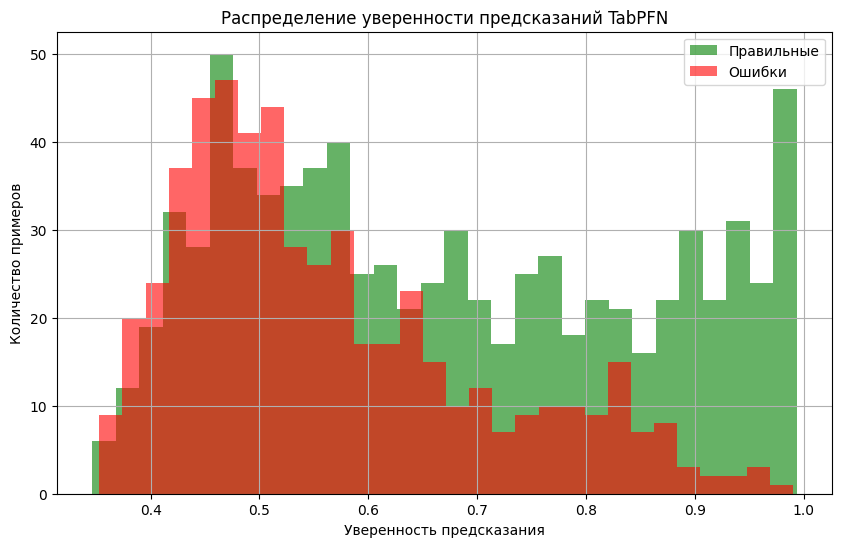

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Получаем вероятности предсказаний
probs = tabpfn_classifier.predict_proba(test_input_clean)

# Максимальная уверенность (confidence) для каждого примера
confidences = np.max(probs, axis=1)

# Метки предсказаний
preds = np.argmax(probs, axis=1)

# Флаг правильности предсказания
correct_mask = (preds == test_target_clean.values)

# Создаем DataFrame для удобства анализа
df_conf = pd.DataFrame({
    'confidence': confidences,
    'correct': correct_mask
})

plt.figure(figsize=(10,6))
plt.hist(df_conf[df_conf['correct']]['confidence'], bins=30, alpha=0.6, label='Правильные', color='green')
plt.hist(df_conf[~df_conf['correct']]['confidence'], bins=30, alpha=0.6, label='Ошибки', color='red')
plt.xlabel('Уверенность предсказания')
plt.ylabel('Количество примеров')
plt.title('Распределение уверенности предсказаний TabPFN')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
thresholds = [0.7, 0.8, 0.9]

for thresh in thresholds:
    mask = confidences >= thresh
    total = np.sum(mask)
    if total == 0:
        print(f"Confidence >= {thresh}: Нет предсказаний")
        continue
    correct = np.sum(correct_mask[mask])
    incorrect = total - correct
    accuracy = correct / total
    print(f"Confidence >= {thresh}:")
    print(f"  Всего предсказаний: {total}")
    print(f"  Правильных: {correct}")
    print(f"  Ошибок: {incorrect}")
    print(f"  Точность: {accuracy:.4f}\n")

Confidence >= 0.7:
  Всего предсказаний: 432
  Правильных: 337
  Ошибок: 95
  Точность: 0.7801

Confidence >= 0.8:
  Всего предсказаний: 283
  Правильных: 234
  Ошибок: 49
  Точность: 0.8269

Confidence >= 0.9:
  Всего предсказаний: 143
  Правильных: 134
  Ошибок: 9
  Точность: 0.9371



In [ ]:
# Фильтрация по confidence >= 0.9
mask_conf = confidences >= 0.9
preds_conf = preds[mask_conf]

# Подсчет количества по классам
class_counts = pd.Series(preds_conf).value_counts(normalize=True) * 100  # в процентах

print(f"Распределение классов при confidence >= 0.9 (в %):")
for cls, pct in class_counts.sort_index().items():
    print(f"  Класс {cls}: {pct:.2f}%")

Распределение классов при confidence >= 0.9 (в %):
  Класс 1: 63.64%
  Класс 2: 36.36%


In [ ]:

total_preds = len(preds)
print(f"Общее количество всех предсказаний: {total_preds}")

class_counts_all = pd.Series(preds).value_counts()
print("Количество предсказаний по классам:")
for cls, count in class_counts_all.sort_index().items():
    print(f"  Класс {cls}: {count}")

Общее количество всех предсказаний: 1330
Количество предсказаний по классам:
  Класс 0: 343
  Класс 1: 502
  Класс 2: 485
